# Seamos sensibles, pero solo un epsilon

### a) Representa la función de pérdida epsilon-insensitive para diferentes valores de epsilon y el error cuadrático en el rango [−3, 3]. ¿Que ventaja te parece que tiene esta función al ignorar los errores menores que un cierto valor?


Me parece que la ventaja que tiene es que evita el overfitting, ya que al ignorar errores pequeños los parámetros no se ajustan tanto al conjunto de entrenamiento.

In [2]:
import jax as jax
import jax.numpy as jnp
from jax import grad, vmap, jit, random

In [3]:
#p son los parametros a optimizar w0 y w1, y x son los datos
#f(x) = w0 + w1x
@jax.jit
def myfunction(p,x):
  return jnp.sum(p * jnp.array([1,x]).T)

##epsilon-insensitiveloss
@jax.jit
def lossINS(p,e,x,y):
  return jnp.maximum(0, jnp.abs(myfunction(p,x) - y) - e);

#error cuadratico medio  
@jax.jit
def lossMSE(p,x,y):
  return (myfunction(p,x) - y)**2

In [4]:
import matplotlib.pyplot as plt

key = random.PRNGKey(0)
x = jnp.linspace(-3,3)
data = vmap(myfunction, in_axes=(None,0))(jnp.array([1,0.7]), x)
y = data + (random.normal(key,(50,)) *0.3)

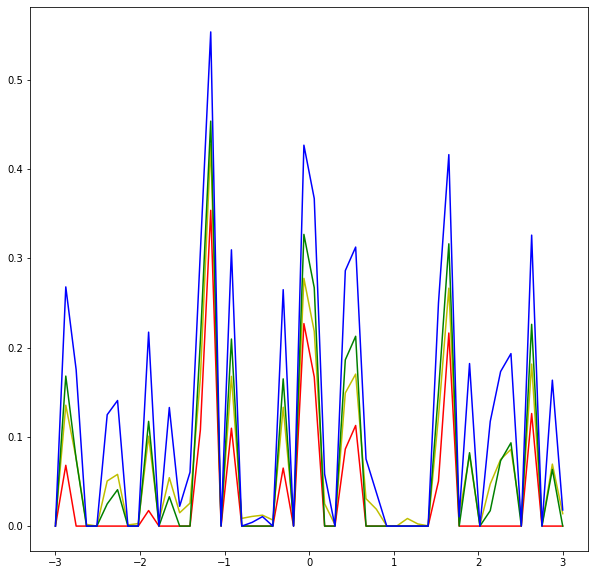

In [5]:
fig = plt.figure(figsize=(10,10))
lossINSfunctionR = vmap(lossINS, in_axes=(None,None,0,0))(jnp.array([1,0.7]),0.3,x,y)
lossINSfunctionG = vmap(lossINS, in_axes=(None,None,0,0))(jnp.array([1,0.7]),0.2,x,y)
lossINSfunctionB = vmap(lossINS, in_axes=(None,None,0,0))(jnp.array([1,0.7]),0.1,x,y)
lossMSEfunction = vmap(lossMSE, in_axes=(None,0,0))(jnp.array([1,0.7]),x,y)
plt.plot(jnp.linspace(-3,3),lossMSEfunction, 'y')
plt.plot(jnp.linspace(-3,3),lossINSfunctionR, 'r')
plt.plot(jnp.linspace(-3,3),lossINSfunctionG, 'g')
plt.plot(jnp.linspace(-3,3),lossINSfunctionB, 'b')
plt.show()

### b) Define un problema de regresión eligiendo dos valores para los parámetros w0 y w1. Genera tres conjuntos de datos de 100 ejemplos usando la distribución uniforme en el rango [0, 20], han de ser tres muestras independientes. Los dos primeros nos servirán de conjunto de entrenamiento y el último como conjunto de test. Calcula la salida para cada ejemplo usando la función: f(x) = w0 + w1 + ruido. El primer ruido sera N(0,1) y el segundo N(0,5). Añade el primer ruido al primer conjunto de datos y el segundo a los oros dos. Junta los dos primeros conjuntos de datos para tener el conjunto de entrenamiento.

In [6]:
key1, key2, key3 = random.split(jax.random.PRNGKey(0),3)
keyN = random.PRNGKey(1)
x1 = random.uniform(key1, shape = (100,), minval = 0, maxval = 20)
x2 = random.uniform(key2, shape = (100,), minval = 0, maxval = 20)
x3 = random.uniform(key3, shape = (100,), minval = 0, maxval = 20)

data1 = vmap(myfunction, in_axes=(None,0))(jnp.array([1,0.7]),x1)
data2 = vmap(myfunction, in_axes=(None,0))(jnp.array([1,0.7]),x2)
data3 = vmap(myfunction, in_axes=(None,0))(jnp.array([1,0.7]),x3)

train1 = data1 + (random.normal(keyN, (100,)) * 1)
train2 = data2 + (random.normal(keyN, (100,)) * 5)
test = data3 + (random.normal(keyN, (100,)) * 5)
train = jnp.concatenate((train1, train2))
x = jnp.concatenate((x1, x2))

### c) Para encontrar los valores de los parámetros implementa un algoritmo de descenso de gradiente con JAX usando la función de pérdida epsilon insensitive. En este caso el usar una tasa de aprendizaje fija puede causar problemas al optimizar. La calcularemos en función de las iteraciones t de la siguiente manera: 

lr(t) = lr0 / (l + lr0 * alpha * t)

### Donde lr0 es una tasa de aprendizaje inicial y alpha es un hiperparámetro que da control adicional sobre cómo desciende la tasa de aprendizaje. 

### Encuentra el mejor conjunto de parámetros explorando los valores [10, 1, 0.1, 0.01, 0.001] para epsilon, lr0 y alpha. Selecciona el mejor conjunto usando el error cuadrático sobre el conjunto de test como criterio. Escoge un número máximo de iteraciones y un valor para decidir el final de la optimización que te parezcan adecuados.

In [8]:
epsilon = 1e-10
grad_INS = jit(grad(lossINS))
bestParams = jnp.array([0.5,1]);
minLoss = 1000000000;
for lr0 in [10, 1, 0.1, 0.01, 0.001]: 
  for e in [10, 1, 0.1, 0.01, 0.001]: 
    for alpha in [10, 1, 0.1, 0.01, 0.001]: 

      paramINS=jnp.array([0.5,1])
      ploss = vmap(lossINS,in_axes=(None,None,0,0))(paramINS, e, x, train).mean(0)
      for i in range(1,1001):
        part = vmap(grad_INS,in_axes=(None,None,0,0))(paramINS,e,x,train)
        lr = (lr0/(1.0*lr0*alpha*i))
        paramINS -= (lr * part.mean(0))
        loss = vmap(lossINS,in_axes=(None,None,0,0))(paramINS,e,x,train).mean(0)
        if jnp.abs(ploss - loss) < epsilon:
          break
        ploss = loss
      
      MSEloss = vmap(lossMSE,in_axes=(None,0,0))(paramINS,x3,test).mean(0)
      if MSEloss < minLoss:
        minLoss = MSEloss
        bestParams = paramINS
        print("MINIMUM LOSS UPDATED ", minLoss, bestParams, " WITH HYPERPARAMETERS ", lr0, e, alpha)
      
print(minLoss, bestParams)

      


MINIMUM LOSS UPDATED  24.9662 [0.4861463  0.76589334]  WITH HYPERPARAMETERS  10 10 10
MINIMUM LOSS UPDATED  24.040424 [0.4824416 0.6778529]  WITH HYPERPARAMETERS  10 10 1
MINIMUM LOSS UPDATED  23.685726 [0.9177625 0.6528481]  WITH HYPERPARAMETERS  10 10 0.1
23.685726 [0.9177625 0.6528481]


### d) Repite el experimento del apartado anterior ajustando los parámetros de la regresión usando el error cuadrático en lugar de la pérdida epsilon-insensitive y seleccionando los mejores también con el error cuadrático en el test. Compara los resultados con los obtenidos en el apartado anterior.

In [ ]:
epsilon = 1e-10
grad_MSE = jit(grad(lossMSE))
bestParams = jnp.array([0.5,1]);
minLoss = 1000000000;
for lr0 in [10, 1, 0.1, 0.01, 0.001]: 
  for e in [10, 1, 0.1, 0.01, 0.001]: 
    for alpha in [10, 1, 0.1, 0.01, 0.001]: 

      paramMSE=jnp.array([0.5,1])
      ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE, x, train).mean(0)
      for i in range(1,1001):
        part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,x,train)
        lr = (lr0/(1*lr0*alpha*i))
        paramMSE -= (lr * part.mean(0))
        loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,x,train).mean(0)
        if jnp.abs(ploss - loss) < epsilon:
          break
        ploss = loss
      
      MSEloss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,x3,test).mean(0)
      if MSEloss < minLoss:
        minLoss = MSEloss
        bestParams = paramINS
        print("MINIMUM LOSS UPDATED ", minLoss, bestParams, " WITH HYPERPARAMETERS ", lr0, e, alpha)
      
print(minLoss, bestParams)

MINIMUM LOSS UPDATED  23.730568 [0.778625  0.7033524]  WITH HYPERPARAMETERS  10 10 10
23.730568 [0.778625  0.7033524]


Se puede observar que en este caso se han obtenido unos valores peores para los parámetros. Usando la epsilon-insensitive loss, los parámetros se ajustaban mucho más a los parámetros reales [1, 0.7]

### Nadie dice que en la optimización no podamos usar una función de pérdida para decidir el cambio en los parámetros y usar otra para decidir cuando acabar la optimización. Repite los experimentos usando el gradiente de la pérdida epsilon-insensitive para ajustar los parámetros y el error cuadrático para acabar la optimización. Selecciona los mejores parámetros de igual manera que en los apartados anteriores. Compara con los resultados anteriores. ¿Por qué no sería buena idea el seleccionar los mejores parámetros usando la pérdida epsilon-insensitive en el conjunto de test?

In [ ]:
epsilon = 1e-10
grad_INS = jit(grad(lossINS))
bestParams = jnp.array([0.5,1]);
minLoss = 1000000000;
for lr0 in [10, 1, 0.1, 0.01, 0.001]: 
  for e in [10, 1, 0.1, 0.01, 0.001]: 
    for alpha in [10, 1, 0.1, 0.01, 0.001]: 

      paramINS=jnp.array([0.5,1])
      ploss = vmap(lossMSE,in_axes=(None,0,0))(paramINS, x, train).mean(0)
      for i in range(1,1001):
        part = vmap(grad_INS,in_axes=(None,None,0,0))(paramINS,e,x,train)
        lr = (lr0/(1*lr0*alpha*i))
        paramINS -= (lr * part.mean(0))
        loss = vmap(lossMSE,in_axes=(None,0,0))(paramINS,x,train).mean(0)
        if jnp.abs(ploss - loss) < epsilon:
          break
        ploss = loss
      
      MSEloss = vmap(lossMSE,in_axes=(None,0,0))(paramINS,x3,test).mean(0)
      if MSEloss < minLoss:
        minLoss = MSEloss
        bestParams = paramINS
        print("MINIMUM LOSS UPDATED ", minLoss, bestParams, " WITH HYPERPARAMETERS ", lr0, e, alpha)
      
print(minLoss, bestParams)

MINIMUM LOSS UPDATED  24.9662 [0.4861463  0.76589334]  WITH HYPERPARAMETERS  10 10 10
MINIMUM LOSS UPDATED  24.04033 [0.48237017 0.67794365]  WITH HYPERPARAMETERS  10 10 1
MINIMUM LOSS UPDATED  23.685726 [0.9177625 0.6528481]  WITH HYPERPARAMETERS  10 10 0.1
23.685726 [0.9177625 0.6528481]


Con este método volvemos a obtener el resultado obtenido en el primer experimento. Por tanto, podríamos asumir que lo que realmente importa para explorar bien los parámetros es el gradiente. No obstante, habría que realizar más experimentos para asegurarlo.

No sería buena idea usar la epsilon-insensitive loss en el conjunto de test porque como uno de los parámetros que estamos optimizando es precisamente la epsilon, no serian comparables los valores de error que devolvería la función cada vez. Además, en el conjunto de test sí que es mejor no ignorar los errores pequeños, ya que estamos mirando cómo de bien se ajusta, no entrenando, así que el overfitting no debe preocuparnos.